# Analysis of MNIST dataset
## -Ravi Teja

Analysis of unsupervised learning methods such as K-Means and EM, dimensionality reduction methods such as PCA,ICA and Random Projections, and their effect on Neural Network classification accuracy.



In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA
from sklearn import metrics,random_projection,mixture
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

In [97]:
train = pd.read_csv("data/train.csv")

In [98]:
#Remove the label data from training data
labels = train['label']
train = train.drop("label",axis=1)

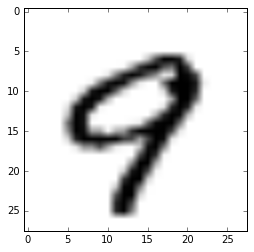

In [99]:
#Visualize a number
fig=plt.imshow(train.iloc[100].as_matrix().reshape(28,28))
fig.set_cmap('gray_r')

In [100]:
#Filter Data - Use 5000 rows
from sklearn.preprocessing import StandardScaler
X = train[:5000].values
labels = labels[:5000].values
#Center the data and scale to unit variance
X_std = StandardScaler().fit_transform(X)

In [6]:
#Assign labels to clusters based on most common label - helps in some analysis later
def asgn_labels(kmeans,labels):
    infer = {}
    for cluster in range(len(kmeans.cluster_centers_)):
        l = [labels[i] for i in range(len(kmeans.labels_)) if kmeans.labels_[i]==cluster]
        infer[cluster] = max(set(l), key=l.count)
    return infer

# K Means

Two metrics are used throughout this analysis for evaluation:
a) Silhouette Coefficient: It is a measure of the mean intra-cluster and mean nearest-cluster distance. The range is [-1,1]. The better the clusters are formed, the higher is the score. This does not use the ground truth label information that we have.
b) Adjusted Mutual Information Score : This measures the mutual information between the formed clusters and the ground truth labels. The mutual information is then adjusted to account for chance. The range is [0,1].

In [7]:
# Apply Kmeans without dimensionality reduction
kmeans = KMeans(n_clusters=10).fit(X_std)
print metrics.silhouette_score(X_std,kmeans.labels_),metrics.adjusted_mutual_info_score(labels,kmeans.labels_)

0.0211419896356 0.423397296958


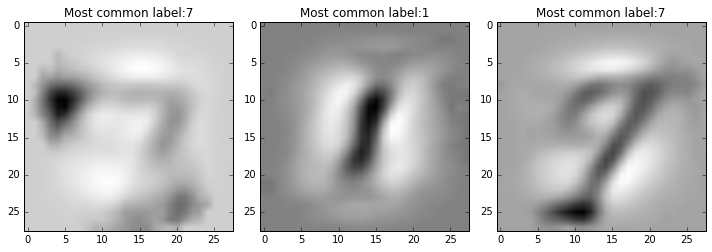

In [8]:
#Visualize a few cluster centroids, along with most common label
clus_labels = asgn_labels(kmeans,labels)
plt.figure(figsize=(10,10))
for c in range(3):
    plt.subplot(1,3,c+1)
    fig=plt.imshow(kmeans.cluster_centers_[c].reshape(28,28))
    fig.set_cmap('gray_r')
    plt.title("Most common label:"+str(clus_labels[c]))
plt.tight_layout()

In [9]:
#Some statistics - most common label occuring in the cluster, and percentage of that label in the cluster
for c in range(6):
    l = [labels[i] for i in range(len(kmeans.labels_)) if kmeans.labels_[i]==c]
    t = max(set(l), key=l.count)
    print "Cluster label:",t," Size:",len(l)," Correct%:",float(len([i for i in l if i==t]))/len(l)

Cluster label: 7  Size: 160  Correct%: 0.56875
Cluster label: 1  Size: 907  Correct%: 0.599779492834
Cluster label: 7  Size: 599  Correct%: 0.387312186978
Cluster label: 2  Size: 308  Correct%: 0.737012987013
Cluster label: 2  Size: 253  Correct%: 0.458498023715
Cluster label: 3  Size: 514  Correct%: 0.470817120623


The correct percentages do not look bad.


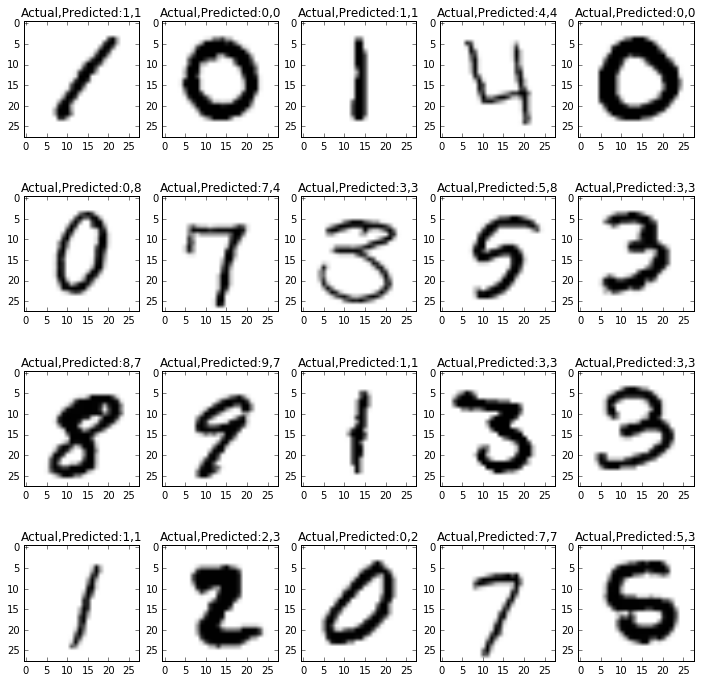

In [10]:
#Visualize actual and predicted labels for few instances
plt.figure(figsize=(12,12))
for inst in range(0,20):
    plt.subplot(4,5,inst+1)
    fig=plt.imshow(train.iloc[inst].as_matrix().reshape(28,28))
    fig.set_cmap('gray_r')
    plt.title("Actual,Predicted:"+str(labels[inst])+","+str(clus_labels[kmeans.labels_[inst]]))

Let us change number of clusters. Ideal expectation is 10 as the number of digits is 10. So a range around 10 is chosen.

In [40]:
#Let us vary number of clusters
def kmeans(data):
    clusters=[] #number of clusters in each iteration
    kmeans_S=[] #the Silhouette coeffs
    kmeans_MI=[]  #the Adjusted MI scores
    times=[] #time for each iteration
    for n in range(2,20,2):
        start=time.time()
        kmeans = KMeans(n_clusters=n,n_init=5).fit(X_std)
        end=time.time()
        clusters.append(n)
        kmeans_S.append(metrics.silhouette_score(data, kmeans.labels_, metric='euclidean'))
        kmeans_MI.append(metrics.adjusted_mutual_info_score(labels,kmeans.labels_))
        times.append(end-start)
    return clusters,kmeans_S,kmeans_MI,times

We will run the above function after defining EM below, so that a comparison can be made.

# EM algorithm

In [12]:
# Vary num clusters of Gaussian Mixture Model (with Full Covariance) and do prediction
def em(data):
    clusters=[]  #store number of clusters
    EM_S=[]
    EM_MI=[]
    times=[]    #Time taken for each iteration
    for n in range(2,20,2):
        start = time.time()
        clf = GaussianMixture(n_components=n, covariance_type='spherical')
        clf.fit(data)
        end=time.time()
        pred=clf.predict(data)
        clusters.append(n)
        EM_S.append(metrics.silhouette_score(X_std, pred, metric='euclidean'))
        EM_MI.append(metrics.adjusted_mutual_info_score(labels,pred))
        times.append(end-start)
    return clusters,EM_S,EM_MI,times

In [13]:
clusters,EM_S,EM_MI,EM_times = em(X_std)

/Users/raviteja/Development/anaconda/envs/gl-env/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [14]:
clusters,kmeans_S,kmeans_MI,kmeans_times = kmeans(X_std)

We will now compare the error metrics and the time taken against the number of clusters. The comparison is between KMeans and EM.

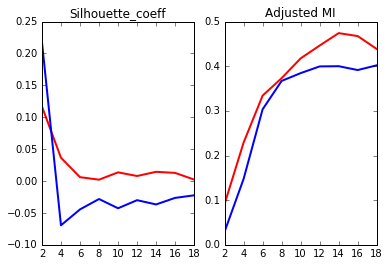

In [15]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,EM_S,'b',linewidth=2.0) #Red represents K Means, Blue represents EM
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_MI,'r',clusters,EM_MI,'b',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

Silhouette coeff increases slowly, but Adjusted Mi improves significantly with increasing clusters.
In both cases, EM is almost equal or slightly better than K Means. 

# 1) Apply PCA

In [56]:
# 1) Apply PCA 
pca =PCA(n_components=265)
pca.fit(X_std)
print pca.explained_variance_ratio_.cumsum()[264]
X_pca = pca.transform(X_std)

0.950170281239


With number of components as 265 (total is 784), the amount of variance retained is around 95%. We will proceed with these components.

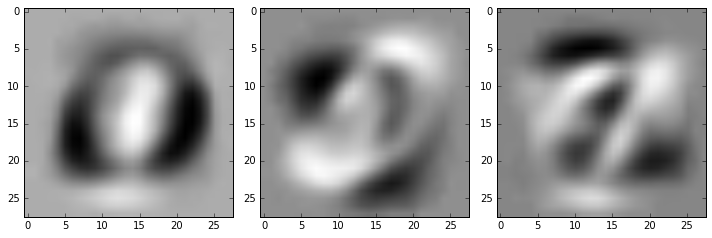

In [60]:
#Let us visualize some of the components(directions) produced by PCA
plt.figure(figsize=(10,10))
for c in range(3):
    plt.subplot(1,3,c+1)
    fig=plt.imshow(pca.components_[c].reshape(28,28))
    fig.set_cmap('gray_r')
plt.tight_layout()

The above components are in descending order of their variance contribution. They have some resemblance to digits: 0 for the first one, and 7 for the last one.

In [19]:
# Apply K-Means with varying k
clusters,KM_pca_S,KM_pca_MI,KM_pca_times = kmeans(X_pca)

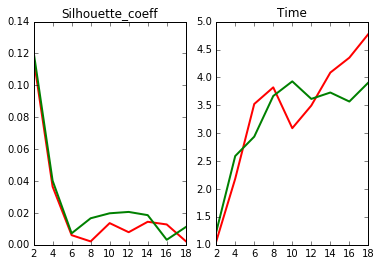

In [20]:
#Comparison of Kmeans with and without PCA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,KM_pca_S,'g',linewidth=2.0) #Red represents without and Green represents with PCA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_times,'r',clusters,KM_pca_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

There is not much gain in the time due to reduced dimensions. The clusters are also relatively poorly formed as shown by low Silhouette coefficient.

In [21]:
# Perform EM with varying number of clusters
clusters,EM_pca_S,EM_pca_MI,EM_pca_times = em(X_pca)

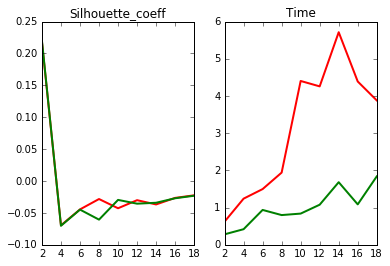

In [85]:
#Comparison of EM with and without PCA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,EM_S,'r',clusters,EM_pca_S,'g',linewidth=2.0) #Red represents without and Green represents with PCA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,EM_times,'r',clusters,EM_pca_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

The time taken for MNIST after PCA is significantly lower than before, whereas this is not the case for Letters dataset. The reason could be that MNIST has significantly more number of features compared to Letters (784 vs 16).


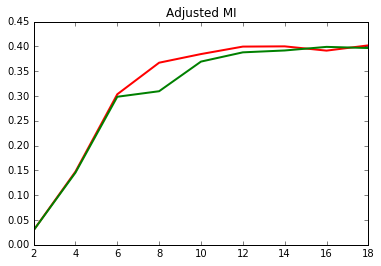

In [23]:
plt.plot(clusters,EM_MI,'r',clusters,EM_pca_MI,'g',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

In both cases, increasing number of clusters increases mutual info with the original labels.

# 2)Apply ICA

In [124]:
ica = FastICA(n_components=265)
S_ = ica.fit_transform(X_std)
A_ = ica.mixing_

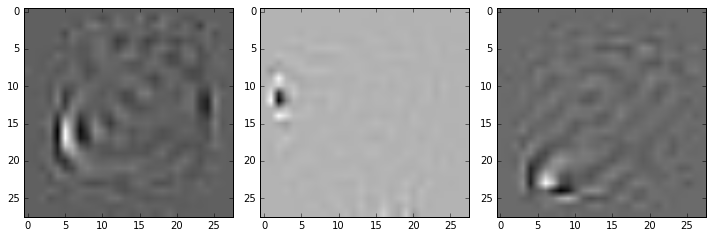

In [67]:
#Let us visualize some of the components(directions) produced by ICA
plt.figure(figsize=(10,10))
for c in range(3):
    plt.subplot(1,3,c+1)
    fig=plt.imshow(ica.components_[c].reshape(28,28))
    fig.set_cmap('gray_r')
plt.tight_layout()

No resemblance to any digits unlike PCA. Seems hard to make any sense from these, but they seem like different gradients at different parts of the image that are independent from each other.

In [25]:
#Vary num clusters for fixed ICA
clusters,KM_ica_S,KM_ica_MI,KM_ica_times = kmeans(S_)

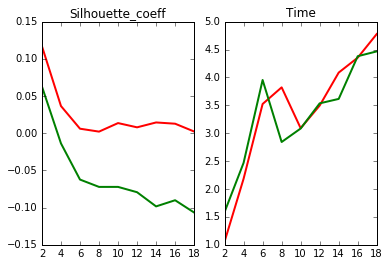

In [26]:
#Comparison of Kmeans with and without ICA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,KM_ica_S,'g',linewidth=2.0) #Red represents without and Green represents with ICA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_times,'r',clusters,KM_ica_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

Though kmeans is not much faster with lesser components, the clusters are considerably less well formed with ICA.

/Users/raviteja/Development/anaconda/envs/gl-env/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


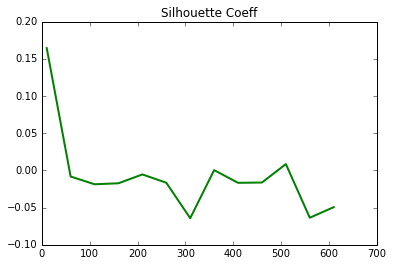

In [27]:
#Let us fix clusters at 10, but Vary ICA parameter and measure silhouette_score
scores=[]
for n_components in range(10,660,50):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X_std)
    kmeans = KMeans(n_clusters=10,n_init=5).fit(S_)
    scores.append((metrics.silhouette_score(S_, kmeans.labels_, metric='euclidean')))
plt.plot(range(10,660,50),scores,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()    

As the number of dimensions increase, it becomes more difficult to form well defined clusters, and hence silhouette_score decreases. We could as well choose a low parameter for K (around 2 for Letters and 20 for MNIST). But we may lose components that contain information related to the actual ground truth labels. So let us perform the above experiment with Adjusted MI to see how well they match with the ground truth.

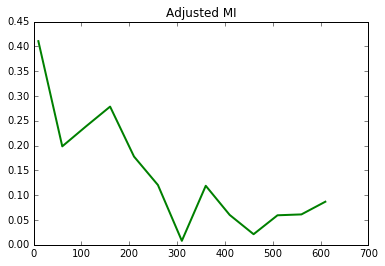

In [28]:
#Let us repeat above experiment this time measuring Adjusted MI
scores=[]
for n_components in range(10,660,50):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X_std)
    kmeans = KMeans(n_clusters=10,n_init=5).fit(S_)
    scores.append(metrics.adjusted_mutual_info_score(labels,kmeans.labels_))
plt.plot(range(10,660,50),scores,'g',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

This is interesting and in contrast to the Letters dataset where we saw an increase in Adjusted MI with increasing components. The reason could be that the number of independent components seems to be low compared to total number of components, and hence there is higher accuracy towards the left of the graph.

In [128]:
#Let's calculate average absolute kurtosis of original data
from scipy.stats import kurtosis
total = 0.0
for i in range(784):
    total += kurtosis(X_std[:,i])
print total/784

451.382920534


In [127]:
#Average kurtosis of transformed data
total = 0
for i in range(265):
    total += kurtosis(S_[:,i])
print total/265

787.450657666


There is an increase in value which shows that the distribution was previously more similar to Gaussian, and less similar after tranformation.

Perfectly Normal distribution has Kurtotis = 0

In [34]:
# Perform EM with varying number of clusters - Used for analysis later
clusters,EM_ica_S,EM_ica_MI,EM_ica_times = em(S_)

# 3) Random Projection

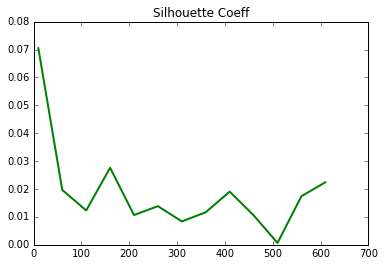

In [35]:
#Let us fix K Means clusters at 10, but vary number of RP components and measure silhouette_score
scores_A=[]
for n_components in range(10,660,50):
    rand = random_projection.GaussianRandomProjection(n_components=n_components)
    X_rand = rand.fit_transform(X_std)
    km = KMeans(n_clusters=10,n_init=5).fit(X_rand)
    scores_A.append((metrics.silhouette_score(X_rand, km.labels_, metric='euclidean')))
plt.plot(range(10,660,50),scores_A,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()  

In [36]:
#Let us fix all parameters constant, but perform repeated runs to see the variation due to randomness of RP
scoresB=[]
for n_components in range(10,660,50):
    rand = random_projection.GaussianRandomProjection(n_components=265)
    X_rand = rand.fit_transform(X_std)
    km = KMeans(n_clusters=10,n_init=5).fit(X_rand)
    scoresB.append((metrics.silhouette_score(X_rand, km.labels_, metric='euclidean')))

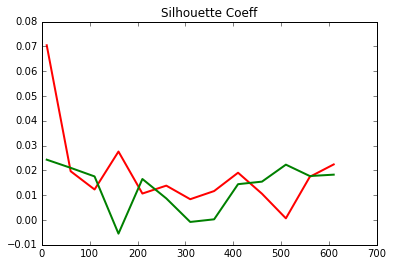

In [38]:
plt.plot(range(10,660,50),scores_A,'r',range(10,660,50),scoresB,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()

The red line above represents variation with respect to RP components. The green line represents repeated runs without changing any of the parameters. The accuracy of RP can change without varying parameters as we choose the components randomly. The purpose of this graph is to compare the variation of RP without parameter change compared to variation of RP with parameter change. The variation of performance of RP is pretty less in this case with and without change in the number of components.

In [41]:
#Perform K-Means with varying num clusters
rand = random_projection.GaussianRandomProjection(n_components=265)
X_rand = rand.fit_transform(X_std)
clusters,KM_rand_S,KM_rand_MI,KM_rand_times = kmeans(X_rand)

In [42]:
# Perform EM with varying number of clusters
clusters,EM_rand_S,EM_rand_MI,EM_rand_times = em(X_rand)

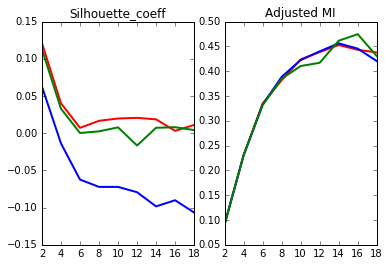

In [43]:
#Plotting the accuracy of all the 3 methods for KMeans - PCA,ICA,RP
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,KM_pca_S,'r',clusters,KM_ica_S,'b',clusters,KM_rand_S,'g',linewidth=2.0) 
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,KM_pca_MI,'r',clusters,KM_ica_MI,'b',clusters,KM_rand_MI,'g',linewidth=2.0) 
plt.title("Adjusted MI")
plt.show()

Although ICA doesn't form clusters as good as PCA and RP, it does as well as others in matching with the original labels.

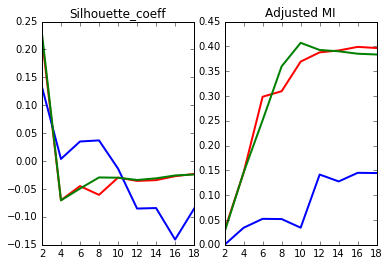

In [44]:
#Plotting the accuracy of all the 3 methods for EM - PCA,ICA,RP
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,EM_pca_S,'r',clusters,EM_ica_S,'b',clusters,EM_rand_S,'g',linewidth=2.0) 
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,EM_pca_MI,'r',clusters,EM_ica_MI,'b',clusters,EM_rand_MI,'g',linewidth=2.0) 
plt.title("Adjusted MI")
plt.show()

In both datasets, RP is able to do as well as others in ground truth classification even though its random.
For MNIST - It seems ICA is not performing well due to high value of parameter(295). Probably the number of independent components are much lesser than 295. An interesting observation is that ICA has low Adjusted MI in the case of EM but not for K_Means. The reason could probably be that a lot of data points lie in the boundaries, and they are lucky enough to be slight closer to the correct cluster, which worked well for K-Means but not the other.

# Reconstruction Error

Let us reconstruct the original data, and see how much information is preserved for each of the dimension reduction algorithms. The metric to evaluate is the mean distance between the original and the new data points.

In [45]:
#Loss function
loss = lambda X,proj: np.sqrt(((X - proj) ** 2).sum(axis=1)).mean()

In [57]:
proj = pca.inverse_transform(X_pca)
print loss(X_std,proj)
proj = ica.inverse_transform(S_)
print loss(X_std,proj)
#Scikit doesn't seem to have inverse_transform for Random Projection. Let's calculate it
from numpy.linalg import inv
proj = np.dot(rand.components_.T,X_rand.T).T
print loss(X_std,proj)

5.46279157742
5.44202470598
39.4720074699


Random projections has significantly higher reconstruction error.

# Neural Network performance after dimension reduction

We train a neural network again with original and PCA reduced data to compare performances.

In [80]:
#Run with original data : choice of hidden layer size=(num_features+output_classes)/2
X_train, X_test, y_train, y_test = train_test_split(X_std, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(395),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.892121212121


In [48]:
#Run after PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.888484848485


The accuracy is almost the same. The reason is probably that the PCA components contain the essential information that is in line with the values of the actual labels, in addition to the max variance captured. 

In [49]:
#Let us change the number of hidden nodes in the single hidden layer and plot the performances
orig_result=[]
pca_result=[]
x_axis=[]
for nodes in range(50,4000,300):
    clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(nodes),alpha=0,learning_rate_init=0.3,momentum=0.9)
    #Original
    X_train, X_test, y_train, y_test = train_test_split(X_std, labels, test_size=0.33, random_state=42)
    clf.fit(X_train,y_train)
    orig_result.append(float(sum(clf.predict(X_test) == y_test))/len(y_test))
    #PCA
    X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.33, random_state=42)
    clf.fit(X_train,y_train)
    pca_result.append(float(sum(clf.predict(X_test) == y_test))/len(y_test))
    x_axis.append(nodes)

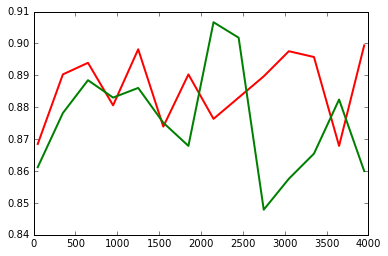

In [73]:
plt.plot(x_axis, orig_result,'r',x_axis,pca_result,'g',linewidth=2.0)
plt.show()

No clear winner here :D

In [51]:
#Let us repeat above experiment for ICA
for n in range(10,660,50):
    ica = FastICA(n_components=n)
    S_ = ica.fit_transform(X_std)
    start = time.time()
    clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(395),alpha=0,learning_rate_init=0.3,momentum=0.9)
    clf.fit(S_,labels)
    end = time.time()
    print n,"  ",float(sum(clf.predict(S_) == labels))/len(labels)

10    0.4966
60    0.614
110    0.7014
160    0.3272
210    0.6444
260    0.9386
310    0.558
360    0.7108
410    0.6972
460    0.6716
510    0.635
560    0.751
610    0.6396


The performance (not even test error, its train error) is very poor and inconsistent. Even with 16 ICs.

# K Means/EM output as a feature for Neural Network

Let us check the neural network performance as above, but with an additional feature which is the clustering output of K Means

In [52]:
kmeans = KMeans(n_clusters=14,n_init=10).fit(X_std)
X = np.concatenate((X_std,kmeans.labels_.T[:,None]),axis=1)
X = StandardScaler().fit_transform(X)
print X.shape

(5000, 785)


In [82]:
# Repeat the Neural Network experiment
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(395),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.884242424242


On an average, the percentage of correct classification remains almost the same and there is not much of an increase(even without this new feature, the accuracy averaged around 85%). It is probably due to clustering feature not providing much extra information than what the NN knows already. Let us check if it the same case after applying PCA.

In [84]:
# Repeat the above experiment after applying PCA
kmeans = KMeans(n_clusters=14,n_init=10).fit(X_pca)
X = np.concatenate((X_pca,kmeans.labels_[:,None]),axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(395),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.878787878788


Even in this case, the percentage remains almost the same